In [22]:
import numpy as np
import pandas as pd 


"""
The range of parameters used to simulate 300,000 call option prices. 
The strike prices K were chosen to lie within the vicinity of the stock price S, so as to be realistic.

---------------------------------------------
Parameter                      Range
---------------------------------------------
Stock price (S)               $10 – $500
Strike price (K)              $7 – $650
Maturity (T)                  1 day to 3 years
Dividend rate (q)             0% – 3%
Risk free rate (r)            1% – 3%
Volatility (σ)                5% – 90%

"""
stock_price = np.random.uniform(10.000000, 500.000000, 300000)
strike_price = np.random.uniform(stock_price * 0.8, stock_price * 1.2, 300000)
maturity = np.random.uniform(0.000913, 3.000000, 300000)
dividends = np.random.uniform(0.000000, 0.030000, 300000)
volatility = np.random.uniform(0.050000, 0.900000, 300000)
risk_free_rate = np.random.uniform(0.010000, 0.030000, 300000)

from scipy import log,exp,sqrt,stats

def bs_call(S,X,T,r,q,sigma):
    """
       Returns: Call value under Black-Schole-Merton option model
               S: current stock price
               X: exercise price
               T: maturity date in years
               r: risk-free rate 
               q: annualized dividend 
           sigma: volatiity of underlying security 
    """
    nsigma = sigma*sqrt(T)
    d1=(log(S/X)+(r-q-0.5*sigma*sigma)*T)/nsigma
    d2 = d1-nsigma
    return S*exp(-q*T)*stats.norm.cdf(d1)-X*exp(-r*T)*stats.norm.cdf(d2)

call_price = bs_call(stock_price, strike_price, maturity, risk_free_rate, dividends, volatility)

list_of_params = list(zip(stock_price, strike_price, maturity, dividends, volatility, risk_free_rate, call_price))
  
# Converting lists of tuples into pandas Dataframe.  
df = pd.DataFrame(list_of_params, columns = ['Stock Price', 'Strike Price', 'Maturity', 'Dividends', 'Volatility', 'Risk-free', 'Call Price'])  
     
# Print df.  
df  

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,205.206784,224.593455,1.406590,0.019532,0.547119,0.010228,34.256519
1,454.349978,483.831020,0.406599,0.025498,0.774646,0.021371,66.707978
2,210.352424,203.215909,0.973710,0.029562,0.898062,0.026425,50.471798
3,424.896751,455.912755,1.916975,0.000297,0.493853,0.010793,83.253787
4,112.121058,115.151915,0.814126,0.021100,0.128763,0.022676,3.843462
...,...,...,...,...,...,...,...
299995,209.973318,226.054476,0.235066,0.000396,0.287216,0.027182,6.018942
299996,389.071059,459.798175,2.257504,0.021333,0.327456,0.016354,40.574703
299997,207.370204,207.085392,0.294981,0.018964,0.500589,0.012144,21.435515
299998,481.498435,505.085259,2.879169,0.012141,0.607724,0.016601,108.020978


In [23]:
## Normalize the data exploiting the fact that the BS Model is linear homogenous in S,K
df["Stock Price"] = df["Stock Price"]/df["Strike Price"]
df["Call Price"] = df["Call Price"]/df["Strike Price"]

In [24]:
## Before feeding the data into TensorFlow, we set it up appropriately into training ( 80% ) and testing data ( 20% ) sets.

n = 300000
n_train =  (int)(0.8 * n)
train = df[0:n_train]
x_train = train[['Stock Price', 'Maturity', 'Dividends', 'Volatility', 'Risk-free']].values
y_train = train['Call Price'].values
test = df[n_train+1:n]
x_test = test[['Stock Price', 'Maturity', 'Dividends', 'Volatility', 'Risk-free']].values
y_test = test['Call Price'].values

In [25]:
## import the TensorFlow and Keras libraries.
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
import tensorflow as tf

In [26]:
''' Because the model aims to produce a positive continuous value for the option price, 
   we cannot use the standard squashing functions that are used in TensorFlow, such as the sigmoid function. 
   These functions emit values in the range  (0,1)  and are not suitable for the range  (0,∞) , which is 
   what we require. Therefore, we need to build our own output node functions, which is shown as a new python 
   function in the following code block. The exponential function is used because it returns positive-only values
'''
def custom_activation(x):
    return backend.exp(x)

In [27]:
'''
Next, set up and compile the model. We have 4 hidden layers of 120 nodes each, and 6 input nodes and a single output node. 
A quick calculation shows that the total number of parameters that need to be fit for the deep learning net is  44,407 . 
The code for this set up is as follows. The loss function used is mean squared error (MSE), and the optimization used the 
RMSprop algorithm
'''

nodes = 120
model = Sequential()

model.add(Dense(nodes, input_dim=X_train.shape[1]))
model.add(LeakyReLU())
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation(custom_activation))
          
model.compile(loss='mse',optimizer='rmsprop')

In [28]:
## We can then run the fitting method to calibrate the model by using loss function MSE. We used 10 epochs.
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=2)

Train on 216000 samples, validate on 24000 samples
Epoch 1/10
 - 15s - loss: 0.0023 - val_loss: 4.5276e-04
Epoch 2/10
 - 27s - loss: 6.4371e-04 - val_loss: 2.2081e-04
Epoch 3/10
 - 18s - loss: 5.1342e-04 - val_loss: 1.2869e-04
Epoch 4/10
 - 18s - loss: 4.2911e-04 - val_loss: 3.9379e-04
Epoch 5/10
 - 18s - loss: 3.6841e-04 - val_loss: 6.4227e-05
Epoch 6/10
 - 18s - loss: 3.1963e-04 - val_loss: 5.2982e-05
Epoch 7/10
 - 18s - loss: 2.7625e-04 - val_loss: 3.7091e-04
Epoch 8/10
 - 18s - loss: 2.3938e-04 - val_loss: 5.4701e-05
Epoch 9/10
 - 18s - loss: 2.1727e-04 - val_loss: 3.8813e-05
Epoch 10/10
 - 18s - loss: 2.0162e-04 - val_loss: 9.0085e-05


Mean Squared Error:       8.891351619095273e-05
Root Mean Squared Error:  0.009429396385291729
Mean Absolute Error:      0.007352143692569896
Mean Percent Error:       0.05468891025329209


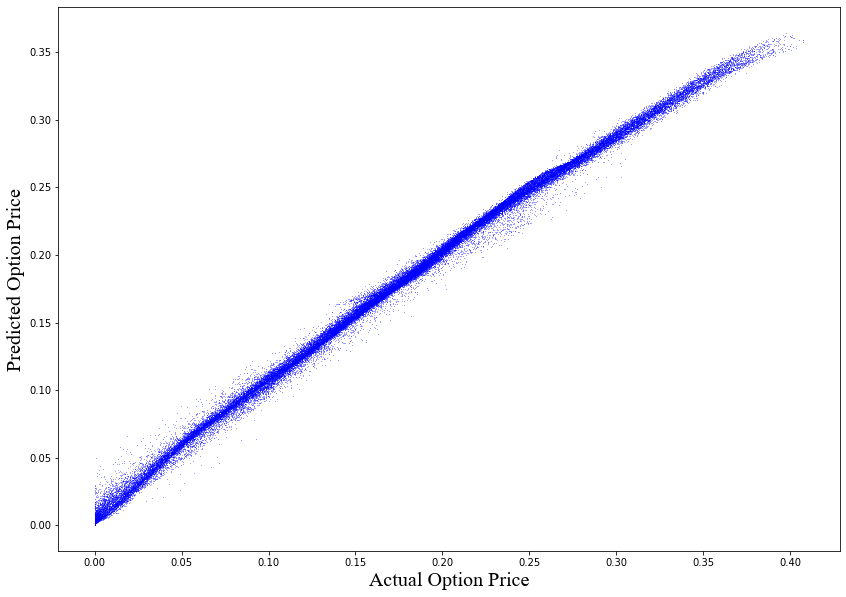

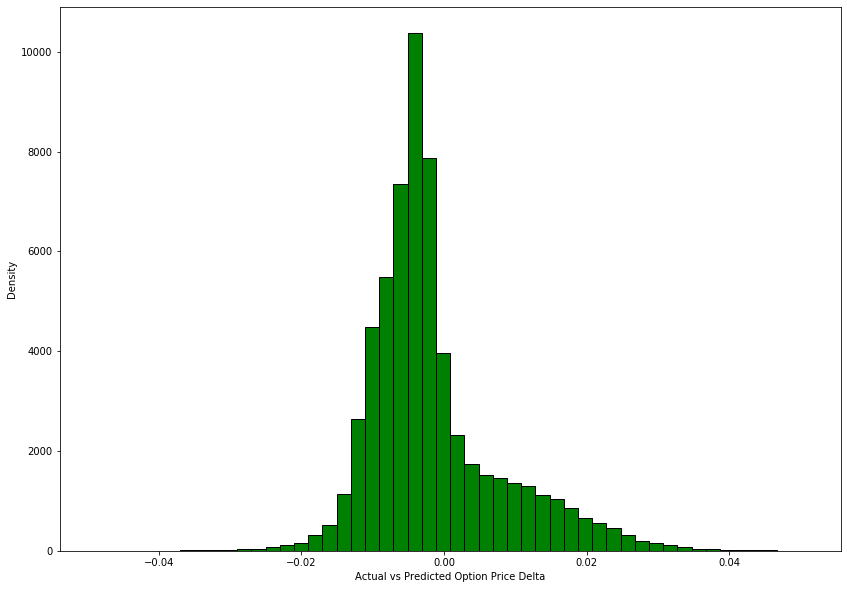

In [30]:
## define a special function to check the accuracy of the model. It generates several common statistics that we may find useful.
def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = np.mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = np.sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = np.mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = np.sqrt(stats['mse'])/np.mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    return stats

## We then obtain the results as follows.
y_test_hat = model.predict(x_test)
#reduce dim (240000,1) -> (240000,) to match y_train's dim
y_test_hat = np.squeeze(y_test_hat)

import matplotlib.pyplot as plt
stats = CheckAccuracy(y_test, y_test_hat)

#plots
plt.rcParams['agg.path.chunksize'] = 100000
plt.figure(figsize=(14,10))
plt.scatter(y_test, y_test_hat,color='blue',linewidth=0.3,alpha=0.4, s=0.5)
plt.xlabel('Actual Option Price',fontsize=20,fontname='Times New Roman')
plt.ylabel('Predicted Option Price',fontsize=20,fontname='Times New Roman') 
plt.show()
    
plt.figure(figsize=(14,10))
plt.hist(stats['diff'], bins=50,edgecolor='black',color='green')
plt.xlabel('Actual vs Predicted Option Price Delta')
plt.ylabel('Density')
plt.show()